In [29]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegem1d import DigFilter
%matplotlib inline
import matplotlib 
matplotlib.rcParams["font.size"] = 14

In [30]:
# eta, tau, c = 0.1, 0.01, 0.5
cs, ncx, ncz, npad = 10., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 0.001
airind = mesh.gridCC[:,2]>0.
actinds = ~airind
# layerind = np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)
layerind = (np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)) & (mesh.gridCC[:,0]<100.)
sigmaInf[airind] = 1e-8
sigmaInf[layerind] = 0.01
eta = np.zeros(mesh.nC)
eta[layerind] = 0.5
tau = np.ones(mesh.nC) * 0.005
c = np.ones(mesh.nC) * 0.5

actmapeta = Maps.InjectActiveCells(mesh, actinds, 0.)
actmaptau = Maps.InjectActiveCells(mesh, actinds, 0.005)
actmapc = Maps.InjectActiveCells(mesh, actinds, 0.5)

wires = Maps.Wires(('eta', actmapeta.nP), ('tau', actmapeta.nP), ('c', actmapeta.nP))

taumap = actmaptau*wires.tau
etamap = actmapeta*wires.eta
cmap = actmapc*wires.c

m = np.r_[eta[actinds], tau[actinds], c[actinds]]

In [31]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
dt = 2e-5
# rx_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+dt, 'z')
# src_ramp = EM.TDEM.Src.CircularLoop([rx_ramp], waveform=EM.TDEM.Src.RampOffWaveform(offTime=dt), loc=srcloc)
rx_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
src_ramp = EM.TDEM.Src.CircularLoop([rx_ramp], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
survey_ramp = EM.TDEM.Survey([src_ramp])
prb_em_ramp = EM.TDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))
# prb_em_ramp.verbose = True
prb_em_ramp.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em_ramp.Solver = PardisoSolver
prb_em_ramp.pair(survey_ramp)
# m = np.r_[sigmaInf, etavec, np.log(tauvec), cvec]
F_ramp = prb_em_ramp.fields(sigmaInf)
data_ramp = survey_ramp.dpred(sigmaInf, f=F_ramp)
cur = []
for t in prb_em_ramp.times:
    cur.append(src_ramp.waveform.eval(t))
cur = np.hstack(cur)

In [32]:
from simpegEMIP.TDEM import geteref, Problem3D_Inductive, Survey

In [33]:
eref_ramp = geteref(F_ramp[src_ramp, 'eSolution', :], mesh, option=None, tInd=1) 

In [34]:
F_ramp[src_ramp, 'eSolution', :].shape

(2451, 86)

In [35]:
prb_em_ramp.times

array([  0.00000000e+00,   1.00000000e-06,   2.00000000e-06,
         3.00000000e-06,   4.00000000e-06,   5.00000000e-06,
         7.50000000e-06,   1.00000000e-05,   1.25000000e-05,
         1.50000000e-05,   1.75000000e-05,   2.25000000e-05,
         2.75000000e-05,   3.25000000e-05,   3.75000000e-05,
         4.25000000e-05,   5.25000000e-05,   6.25000000e-05,
         7.25000000e-05,   8.25000000e-05,   9.25000000e-05,
         1.02500000e-04,   1.12500000e-04,   1.22500000e-04,
         1.32500000e-04,   1.42500000e-04,   1.62500000e-04,
         1.82500000e-04,   2.02500000e-04,   2.22500000e-04,
         2.42500000e-04,   2.62500000e-04,   2.82500000e-04,
         3.02500000e-04,   3.22500000e-04,   3.42500000e-04,
         3.82500000e-04,   4.22500000e-04,   4.62500000e-04,
         5.02500000e-04,   5.42500000e-04,   5.82500000e-04,
         6.22500000e-04,   6.62500000e-04,   7.02500000e-04,
         7.42500000e-04,   8.22500000e-04,   9.02500000e-04,
         9.82500000e-04,

In [47]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
rx_ip_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
src_ip_ramp = EM.TDEM.Src.CircularLoop([rx_ip_ramp], waveform=EM.TDEM.Src.RampOffWaveform(offTime=0.), loc=srcloc)
dt = 1e-6
survey_ip_ramp = Survey([src_ip_ramp])
prb_ip_ramp = Problem3D_Inductive(
    mesh, 
    sigmaInf=sigmaInf, 
    etaMap=etamap, 
    tauMap=taumap, 
    cMap=cmap, 
    actinds = ~airind,
    tlags = [0, dt], 
#     wave_option = "impulse"
)
prb_ip_ramp.Solver = PardisoSolver
prb_ip_ramp.pair(survey_ip_ramp)
prb_ip_ramp.set_eref(eref_ramp)
ip_ramp_approx = survey_ip_ramp.dpred(m)

>> Compute Sensitivity matrix
 0 / 1

In [48]:
data = np.load("data.npy")
data_ramp = np.load("data_ramp.npy")
data_vtem = np.load("data_vtem.npy")

data_em = np.load("dataem.npy")
data_em_ramp = np.load("dataem_ramp.npy")
data_em_vtem = np.load("dataem_vtem.npy")
ip = data - data_em
ip_ramp = data_ramp - data_em_ramp
ip_vtem = data_vtem - data_em_vtem

In [49]:
data.shape

(51,)

In [50]:
data_em.shape

(51,)

In [51]:
data_ramp_approx = data_em + ip_ramp_approx

In [52]:
# J = np.load("J.npy")

In [53]:
# plt.semilogy(abs(J[actinds]))
# plt.semilogy(abs(prb_ip_ramp.J.flatten())[actinds], '.')

In [54]:
# plt.loglog(rx_ip_ramp.times, -data_ramp, 'k')
# plt.loglog(rx_ip_ramp.times, data_ramp, '--k')
# plt.loglog(rx_ip_ramp.times, -data_em_ramp, 'b-')
# plt.loglog(rx_ip_ramp.times, ip_ramp, 'r-')
# plt.plot(rx_ip_ramp.times, ip_ramp_approx, 'r.')

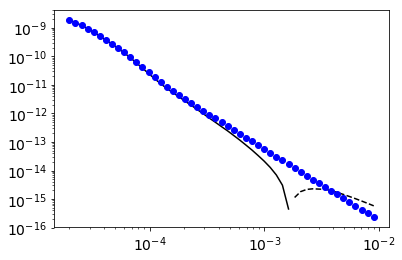

In [55]:
plt.loglog(rx_ip_ramp.times, -data, 'k')
plt.loglog(rx_ip_ramp.times, data, '--k')
# plt.loglog(rx_ip_ramp.times, -data_ramp, 'k')
# plt.loglog(rx_ip_ramp.times, data_ramp, '--k')

plt.loglog(rx_ip_ramp.times, -data_ramp_approx, 'bo')
plt.loglog(rx_ip_ramp.times, data_ramp_approx, 'b.')